In [10]:
import warnings
warnings.filterwarnings('ignore')
import logging
import os

from topic_.text_preprocessing import *
from bertopic.topic_modeling import *
from modules.data_loader import *
import json
import pandas as pd

ModuleNotFoundError: No module named 'bertopic.text_preprocessing'

In [4]:
# Load the YAML configuration file
import yaml
with open('../config.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)

In [ ]:
with open(f"data/documents-{docs_type}.json", "r") as file:
    json.dump(others, file)

## Dash

In [ ]:
import plotly.io as pio

# Assume `topic_model` is your trained BERTopic model
fig_topic_clusters = topic_model.visualize_topics(custom_labels=True)

# Save the visualization as an HTML string
html_topic_clusters = pio.to_html(fig_topic_clusters, include_plotlyjs=False)

import plotly.graph_objects as go

def visualize_topic_term(
    topic_model,
    topic: int,
    n_words: int = 10,
    title: str = "<b>Top Keywords</b>",
) -> go.Figure:
    colors = itertools.cycle(["#636EFA", "#EF553B", "#00CC96", "#AB63FA", "#FFA15A", "#19D3F3", "#FF6692"])

    # Get the words and scores for the specific topic
    words = [word + "  " for word, _ in topic_model.get_topic(topic)][:n_words][::-1]
    scores = [score for _, score in topic_model.get_topic(topic)][:n_words][::-1]

    # Create the bar chart
    fig = go.Figure()

    fig.add_trace(
        go.Bar(x=scores, y=words, orientation="h", marker_color=next(colors))
    )

    # Stylize graph
    fig.update_layout(
        template="plotly_white",
        showlegend=False,
        title={
            "text": f"{title}",
            "x": 0.5,
            "xanchor": "center",
            "yanchor": "top",
            "font": dict(size=22, color="Black"),
        },
        width=400,
        height=400,
        hoverlabel=dict(bgcolor="white", font_size=16, font_family="Source Sans Pro"),
    )

    fig.update_xaxes(showgrid=True)
    fig.update_yaxes(showgrid=True)

    return fig


In [1]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

# Initialize the Dash app
app = dash.Dash(__name__)

# Define the layout of the app
app.layout = html.Div([
    # BERTopic Visualization
    dcc.Graph(
        id='topic-cluster-plot',
        figure=fig_topic_clusters,
        config={'displayModeBar': False}
    ),
    
    # Bar Chart Visualization
    dcc.Graph(
        id='keyword-bar-chart',
        figure=visualize_topic_term(topic_model, topic=0)  # Default to first topic
    )
])

# Define callback to update bar chart based on hover
@app.callback(
    Output('keyword-bar-chart', 'figure'),
    [Input('topic-cluster-plot', 'hoverData')]
)
def update_bar_chart(hoverData):
    if hoverData is not None:
        # Extract the topic number from hoverData
        point_data = hoverData['points'][0]
        topic_number = point_data['customdata'][0]  # Ensure this matches the customdata field in BERTopic plot

        # Update the bar chart with the new topic
        return visualize_topic_term(topic_model, topic=topic_number)
    return visualize_topic_term(topic_model, topic=0)  # Default

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## RAG

In [186]:
import re
import os
import sqlite3

from langchain_community.document_loaders import PyPDFLoader

folder_path = "Data/Non-profits and NGOs/"

# Initialize a list to store the pages from all PDFs
all_pages = []

# Iterate through each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".pdf"):  # Ensure the file is a PDF
        # Construct the full path to the PDF file
        file_path = os.path.join(folder_path, filename)
        print(file_path)
        
        # Initialize the PyPDFLoader for the current PDF file
        loader = PyPDFLoader(file_path)
        
        # Load and split the pages of the current PDF file
        pages = loader.load()
        print(pages)
        
        # Extend the list of all pages with the pages from the current PDF
        all_pages.extend(pages)

from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=3000, chunk_overlap=200, add_start_index=True
)

# Split the text of all pages
all_splits = text_splitter.split_documents(all_pages)

from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
embedding = OpenAIEmbeddings(model="text-embedding-3-small",
                             api_key=openai_api_key
                             )
vectorstore = Chroma.from_documents(documents=all_splits, embedding=embedding)

# Set up retriever with vector store
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 3})
retrieved_docs = retriever.invoke("What obligations do GenAI developers have?")
print(retrieved_docs[0].page_content)

from langchain_openai import ChatOpenAI
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

llm = ChatOpenAI(model="gpt-3.5-turbo-0125",
                 api_key=openai_api_key)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Customize the prompt
from langchain_core.prompts import PromptTemplate
template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Keep the answer concise, yet professional and informative. Always cite the source of the information.

{context}

Question: {question}

Helpful Answer:"""

custom_rag_prompt = PromptTemplate.from_template(template)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | custom_rag_prompt #default_prompt
    | llm
    | StrOutputParser()
)

rag_chain.invoke("What obligations do GenAI developers have?")

Data/Non-profits and NGOs/2023-12-15-Civic-Tech-Declining-Teacher-Trust-In-Students-issue-brief-final.pdf
[Document(metadata={'source': 'Data/Non-profits and NGOs/2023-12-15-Civic-Tech-Declining-Teacher-Trust-In-Students-issue-brief-final.pdf', 'page': 0}, page_content='The Shortcomings of Generative AI Detection: How Schools Should \nApproach Declining Teacher Trust In Students\nGenerative AI – systems that use machine learning to produce new content (e.g., textor images) in response to user prompts – has infiltrated the education system and fundamentally shifted the relationships between teachers and their students. \nAcross the country, educators have expressed high levels of anxiety about students using \ngenerative AI tools, like ChatGPT, to cheat on assignments, exams, and essays in addition to fears of students losing critical thinking skills. One professor even described it as  having “infected [the \neducation system] like a deathwatch beetle, hollowing out sound structures fr

be entirely protected under current U.S. copyright laws (since humans did not create 
it), acc ording to current court rulings and U.S. Copyright Office policies.  Moreover, 
certain generative AI tools may limit the user’s ownership rights in the work the 
platform generates.  
 
• Note: The above guidelines also apply to confidential, internal agency 
information.  
 
2. We honor our role in society.  
 
• Do not use generative AI to create or spread deepfakes, nor misinformation or 
disinformation.   
 
3. We are committed to accuracy.  
 
• Always check and source the data generative AI tools provide.  Always validate 
the cla ims with your own search of the source. Just because the tool says it came 
from a source does not mean it did, as some generative AI chat tools are 
exceptionally good at convincingly fabricating information.  
 
• Always check for inadvertent plagiarism, copyri ght infringement, or trademark 
infringement in AI -generated output.  
 
• Ask vendors about how

'GenAI developers have obligations to ensure compliance with relevant US copyright laws, avoid the creation or spread of deepfakes, misinformation, or disinformation, check and source data provided by AI tools, validate claims independently, check for inadvertent plagiarism, copyright infringement, or trademark infringement, and disclose the use of generative AI tools in the creative process to clients. Additionally, developers must follow the policies of external systems requiring attribution for AI-generated output.'

## Visualization

In [117]:
import numpy as np
import pandas as pd
from typing import List, Union
from umap import UMAP
from warnings import warn

try:
    import datamapplot
    from matplotlib.figure import Figure
except ImportError:
    warn("Data map plotting is unavailable unless datamapplot is installed.")

    # Create a dummy figure type for typing
    class Figure(object):
        pass


def visualize_document_datamap(
    topic_model,
    docs: List[str],
    topics: List[int] = None,
    embeddings: np.ndarray = None,
    reduced_embeddings: np.ndarray = None,
    custom_labels: Union[bool, str] = False,
    title: str = "Documents and Topics",
    sub_title: Union[str, None] = None,
    width: int = 1200,
    height: int = 1200,
    **datamap_kwds,
) -> Figure:
    """Visualize documents and their topics in 2D as a static plot for publication using
    DataMapPlot.

    Arguments:
        topic_model:  A fitted BERTopic instance.
        docs: The documents you used when calling either `fit` or `fit_transform`
        topics: A selection of topics to visualize.
                Not to be confused with the topics that you get from `.fit_transform`.
                For example, if you want to visualize only topics 1 through 5:
                `topics = [1, 2, 3, 4, 5]`. Documents not in these topics will be shown
                as noise points.
        embeddings:  The embeddings of all documents in `docs`.
        reduced_embeddings:  The 2D reduced embeddings of all documents in `docs`.
        custom_labels:  If bool, whether to use custom topic labels that were defined using
                       `topic_model.set_topic_labels`.
                       If `str`, it uses labels from other aspects, e.g., "Aspect1".
        title: Title of the plot.
        sub_title: Sub-title of the plot.
        width: The width of the figure.
        height: The height of the figure.
        **datamap_kwds:  All further keyword args will be passed on to DataMapPlot's
                         `create_plot` function. See the DataMapPlot documentation
                         for more details.

    Returns:
        figure: A Matplotlib Figure object.

    Examples:
    To visualize the topics simply run:

    ```python
    topic_model.visualize_document_datamap(docs)
    ```

    Do note that this re-calculates the embeddings and reduces them to 2D.
    The advised and preferred pipeline for using this function is as follows:

    ```python
    from sklearn.datasets import fetch_20newsgroups
    from sentence_transformers import SentenceTransformer
    from bertopic import BERTopic
    from umap import UMAP

    # Prepare embeddings
    docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']
    sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = sentence_model.encode(docs, show_progress_bar=False)

    # Train BERTopic
    topic_model = BERTopic().fit(docs, embeddings)

    # Reduce dimensionality of embeddings, this step is optional
    # reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

    # Run the visualization with the original embeddings
    topic_model.visualize_document_datamap(docs, embeddings=embeddings)

    # Or, if you have reduced the original embeddings already:
    topic_model.visualize_document_datamap(docs, reduced_embeddings=reduced_embeddings)
    ```

    Or if you want to save the resulting figure:

    ```python
    fig = topic_model.visualize_document_datamap(docs, reduced_embeddings=reduced_embeddings)
    fig.savefig("path/to/file.png", bbox_inches="tight")
    ```
    <img src="../../getting_started/visualization/datamapplot.png",
         alt="DataMapPlot of 20-Newsgroups", width=800, height=800></img>
    """
    topic_per_doc = topic_model.topics_

    df = pd.DataFrame({"topic": np.array(topic_per_doc)})
    df["doc"] = docs
    df["topic"] = topic_per_doc

    # Extract embeddings if not already done
    if embeddings is None and reduced_embeddings is None:
        embeddings_to_reduce = topic_model._extract_embeddings(df.doc.to_list(), method="document")
    else:
        embeddings_to_reduce = embeddings

    # Reduce input embeddings
    if reduced_embeddings is None:
        umap_model = UMAP(n_neighbors=15, n_components=2, min_dist=0.15, metric="cosine").fit(embeddings_to_reduce)
        embeddings_2d = umap_model.embedding_
    else:
        embeddings_2d = reduced_embeddings

    unique_topics = set(topic_per_doc)

    # Prepare text and names
    if isinstance(custom_labels, str):
        names = [[[str(topic), None]] + topic_model.topic_aspects_[custom_labels][topic] for topic in unique_topics]
        names = [" ".join([label[0] for label in labels[:4]]) for labels in names]
        names = [label if len(label) < 30 else label[:27] + "..." for label in names]
    elif topic_model.custom_labels_ is not None and custom_labels:
        names = [topic_model.custom_labels_[topic + topic_model._outliers] for topic in unique_topics]
    else:
        names = [
            f"Topic-{topic}: " + " ".join([word for word, value in topic_model.get_topic(topic)][:3])
            for topic in unique_topics
        ]

    topic_name_mapping = {topic_num: topic_name for topic_num, topic_name in zip(unique_topics, names)}
    topic_name_mapping[-1] = "Unlabelled"

    # If a set of topics is chosen, set everything else to "Unlabelled"
    if topics is not None:
        selected_topics = set(topics)
        for topic_num in topic_name_mapping:
            if topic_num not in selected_topics:
                topic_name_mapping[topic_num] = "Unlabelled"

    # Map in topic names and plot
    named_topic_per_doc = pd.Series(topic_per_doc).map(topic_name_mapping).values

    figure, axes = datamapplot.create_interactive_plot(
        embeddings_2d,
        named_topic_per_doc,
        figsize=(width / 100, height / 100),
        dpi=100,
        title=title,
        sub_title=sub_title,
        **datamap_kwds,
    )

    return figure

In [127]:
import numpy as np
import pandas as pd
from typing import List, Union
from umap import UMAP
from warnings import warn

try:
    import datamapplot
    from matplotlib.figure import Figure
except ImportError:
    warn("Data map plotting is unavailable unless datamapplot is installed.")

    # Create a dummy figure type for typing
    class Figure(object):
        pass


def visualize_document_datamap(
    topic_model,
    docs: List[str],
    topics: List[int] = None,
    embeddings: np.ndarray = None,
    reduced_embeddings: np.ndarray = None,
    custom_labels: Union[bool, str] = False,
    title: str = "Documents and Topics",
    sub_title: Union[str, None] = None,
    width: int = 1200,
    height: int = 1200,
    **datamap_kwds,
) -> Figure:
    """Visualize documents and their topics in 2D as a static plot for publication using
    DataMapPlot.

    Arguments:
        topic_model:  A fitted BERTopic instance.
        docs: The documents you used when calling either `fit` or `fit_transform`
        topics: A selection of topics to visualize.
                Not to be confused with the topics that you get from `.fit_transform`.
                For example, if you want to visualize only topics 1 through 5:
                `topics = [1, 2, 3, 4, 5]`. Documents not in these topics will be shown
                as noise points.
        embeddings:  The embeddings of all documents in `docs`.
        reduced_embeddings:  The 2D reduced embeddings of all documents in `docs`.
        custom_labels:  If bool, whether to use custom topic labels that were defined using
                       `topic_model.set_topic_labels`.
                       If `str`, it uses labels from other aspects, e.g., "Aspect1".
        title: Title of the plot.
        sub_title: Sub-title of the plot.
        width: The width of the figure.
        height: The height of the figure.
        **datamap_kwds:  All further keyword args will be passed on to DataMapPlot's
                         `create_plot` function. See the DataMapPlot documentation
                         for more details.

    Returns:
        figure: A Matplotlib Figure object.

    Examples:
    To visualize the topics simply run:

    ```python
    topic_model.visualize_document_datamap(docs)
    ```

    Do note that this re-calculates the embeddings and reduces them to 2D.
    The advised and preferred pipeline for using this function is as follows:

    ```python
    from sklearn.datasets import fetch_20newsgroups
    from sentence_transformers import SentenceTransformer
    from bertopic import BERTopic
    from umap import UMAP

    # Prepare embeddings
    docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']
    sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = sentence_model.encode(docs, show_progress_bar=False)

    # Train BERTopic
    topic_model = BERTopic().fit(docs, embeddings)

    # Reduce dimensionality of embeddings, this step is optional
    # reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

    # Run the visualization with the original embeddings
    topic_model.visualize_document_datamap(docs, embeddings=embeddings)

    # Or, if you have reduced the original embeddings already:
    topic_model.visualize_document_datamap(docs, reduced_embeddings=reduced_embeddings)
    ```

    Or if you want to save the resulting figure:

    ```python
    fig = topic_model.visualize_document_datamap(docs, reduced_embeddings=reduced_embeddings)
    fig.savefig("path/to/file.png", bbox_inches="tight")
    ```
    <img src="../../getting_started/visualization/datamapplot.png",
         alt="DataMapPlot of 20-Newsgroups", width=800, height=800></img>
    """
    topic_per_doc = topic_model.topics_

    df = pd.DataFrame({"topic": np.array(topic_per_doc)})
    df["doc"] = docs
    df["topic"] = topic_per_doc

    # Extract embeddings if not already done
    if embeddings is None and reduced_embeddings is None:
        embeddings_to_reduce = topic_model._extract_embeddings(df.doc.to_list(), method="document")
    else:
        embeddings_to_reduce = embeddings

    # Reduce input embeddings
    if reduced_embeddings is None:
        umap_model = UMAP(n_neighbors=15, n_components=2, min_dist=0.15, metric="cosine").fit(embeddings_to_reduce)
        embeddings_2d = umap_model.embedding_
    else:
        embeddings_2d = reduced_embeddings

    unique_topics = set(topic_per_doc)

    # Prepare text and names
    if isinstance(custom_labels, str):
        names = [[[str(topic), None]] + topic_model.topic_aspects_[custom_labels][topic] for topic in unique_topics]
        names = [" ".join([label[0] for label in labels[:4]]) for labels in names]
        names = [label if len(label) < 30 else label[:27] + "..." for label in names]
    elif topic_model.custom_labels_ is not None and custom_labels:
        names = [topic_model.custom_labels_[topic + topic_model._outliers] for topic in unique_topics]
    else:
        names = [
            f"Topic-{topic}: " + " ".join([word for word, value in topic_model.get_topic(topic)][:3])
            for topic in unique_topics
        ]

    topic_name_mapping = {topic_num: topic_name for topic_num, topic_name in zip(unique_topics, names)}
    topic_name_mapping[-1] = "Unlabelled"

    # If a set of topics is chosen, set everything else to "Unlabelled"
    if topics is not None:
        selected_topics = set(topics)
        for topic_num in topic_name_mapping:
            if topic_num not in selected_topics:
                topic_name_mapping[topic_num] = "Unlabelled"

    # Map in topic names and plot
    named_topic_per_doc = pd.Series(topic_per_doc).map(topic_name_mapping).values

    figure, axes = datamapplot.create_plot(
        embeddings_2d,
        named_topic_per_doc,
        #figsize=(width / 100, height / 100),
        #dpi=100,
        title=title,
        sub_title=sub_title,
        **datamap_kwds,
    )

    return figure

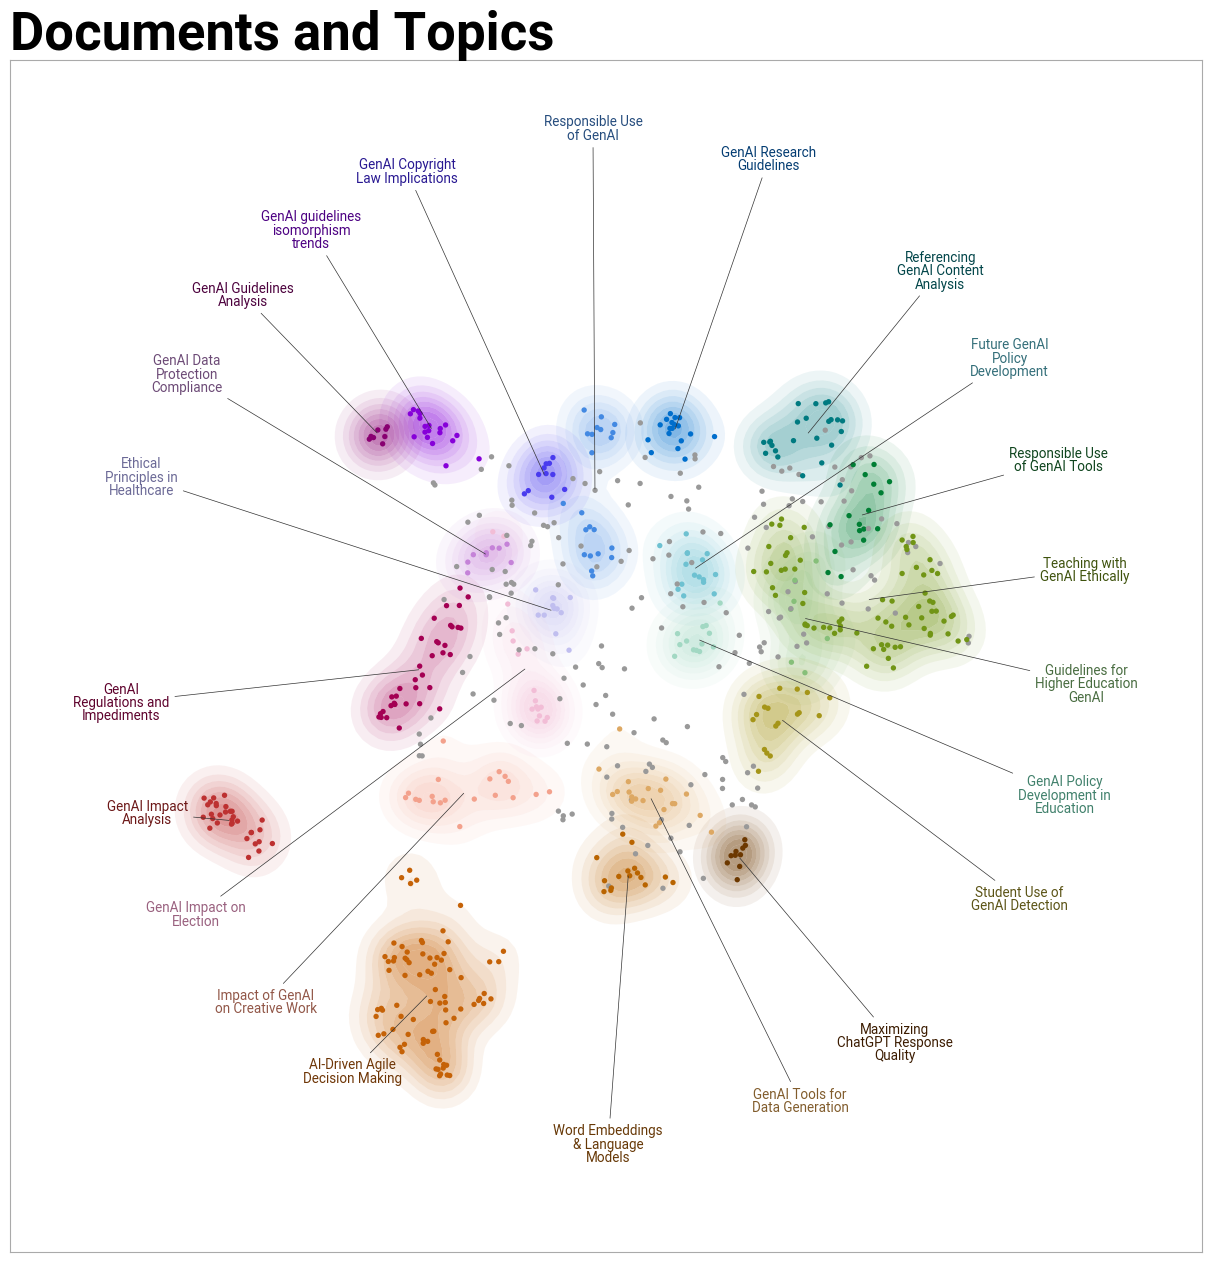

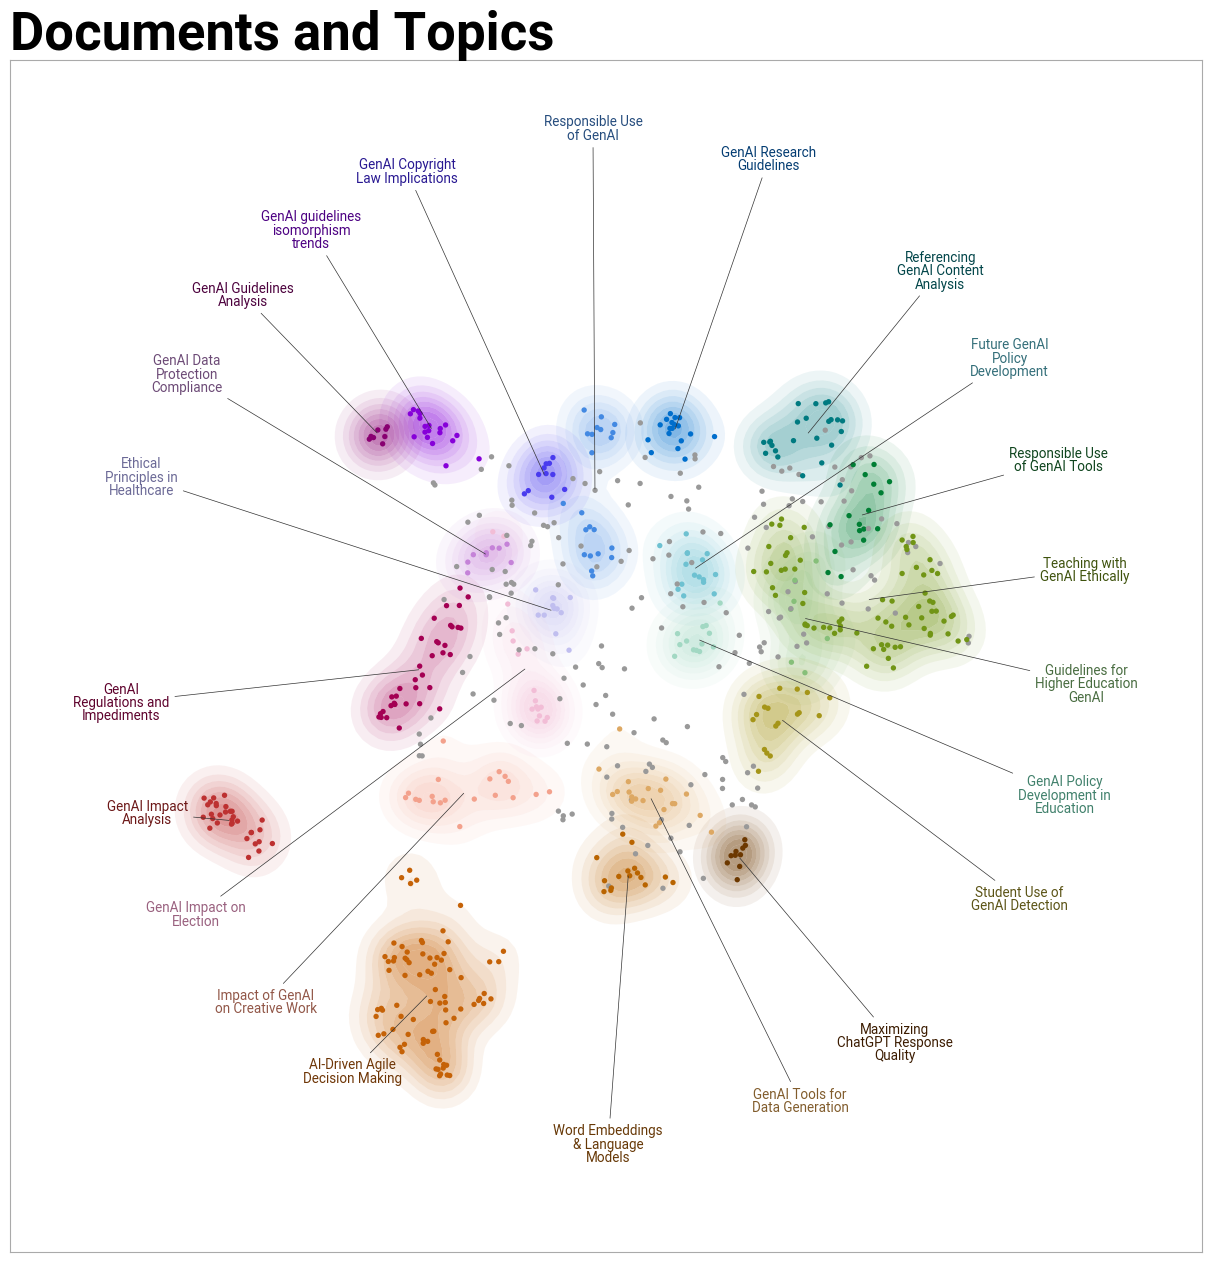

In [ ]:
datamap = visualize_document_datamap(topic_model_5, docs=edu_sec_lower, embeddings=embeddings_5, custom_labels=True)
pio.write_html(datamap, 'datamap.html', auto_open=False)

## Clustering Interpretation                                                                            

In [24]:
umap = UMAP(n_components=2, metric='cosine')
topic_coordinates = umap.fit_transform(embeddings_5)

In [31]:
topic_coordinates

array([[ 7.973014 , 12.675497 ],
       [13.181692 , 11.02687  ],
       [12.142796 ,  9.650928 ],
       ...,
       [10.5064125, 12.61659  ],
       [ 9.068459 , 13.674063 ],
       [ 8.9764805, 12.787165 ]], dtype=float32)

## Clustering Interpretation v1

In [ ]:
def create_empty_dict(directory):
    markdown_files = [f for f in os.listdir(directory) if f.endswith('.md')]
    result = {markdown_file: {} for markdown_file in markdown_files}
    return result

result = create_empty_dict('data/Education and Academia')

def save_sections_to_list(directory):
    sections_list = []
    markdown_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.md')]
    token_splitter = NLTKTextSplitter(chunk_size=3000)

    for markdown_file in markdown_files:
        try:
            with open(markdown_file, 'r', encoding='utf-8') as file:
                markdown_text = file.read()
                sections = split_markdown_by_section(markdown_text)
                filtered_sections = filter_sections(sections)
                
                for section in filtered_sections:
                    chunks = token_splitter.split_text(section)
                    sections_list.extend(chunks)
            
            # If the file was processed successfully, add it to the result dictionary with chunk index of each markdown as key and content as value
            result[os.path.basename(markdown_file)] = {i: section for i, section in enumerate(sections_list)}
            
        except Exception as e:
            logging.error(f"Error processing file {markdown_file}: {e}")
    
    return sections_list

In [ ]:
import pandas as pd

def add_topic_to_dict(doc_dict, df):
    new_dict = {}
    for doc, sections in doc_dict.items():
        new_dict[doc] = {}
        for section_id, section_content in sections.items():
            # Filter the DataFrame to get the row matching the section content
            row = df[df['Document'] == section_content].iloc[0]
            topic_index = row['OpenAI']
            keywords = row['Top_n_words']

            # Construct the nested dictionary structure
            new_dict[doc][section_id] = {
                section_content: {
                    topic_index: keywords
                }
            }
    return new_dict

new_dict = add_topic_to_dict(result, test_doc_info)

In [ ]:
def split_md_into_sections(md_text):
    # Lowercase the markdown text to make the regex case-insensitive
    md_text = md_text.lower()

    # Delete figures and images
    md_text = re.sub(r'!\[.*?\]\(.*?\)', '', md_text)

    # Use regex to find headers and bold text that start sections
    pattern = r'(^# .+?$|^\*\*.+?\*\*$)'
    
    # Split the text at each match, keeping the match as a separate section
    sections = re.split(pattern, md_text, flags=re.MULTILINE)
    
    # Combine the matches and their following texts
    combined_sections = []
    for i in range(0, len(sections), 2):
        header = sections[i].strip() if i < len(sections) else ''
        content = sections[i + 1].strip() if i + 1 < len(sections) else ''
        combined_sections.append((header,content))
    
    return combined_sections